In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import rasterio
import numpy as np
import torch.nn as nn
import torch.optim as optim
from skimage.transform import resize
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import geometry_mask

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tif_path = "G:/16_ECMWF/7_climate_10_520_400/1_tem/2017/tem_2017_01_01.tif"
with rasterio.open(tif_path) as src:
        image_data = src.read(1)  # 读取第一个波段
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
        height, width = src.height, src.width
        profile = src.profile  # 获取文件元数据以便后续导出
    
shp_path = "C:/Users/Administrator/Desktop/边界/九大农业区/Agr_qu.shp"
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(crs)
geometries = [mapping(geometry) for geometry in shapefile.geometry]
mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(height, width))

Using device: cuda


In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, tem_dirs, tem_min_dirs, tem_max_dirs, pr_dirs, wind_dirs, ps_dirs, solar_dirs, ther_dirs, rh_dirs, eva_dirs, transform=None):
        self.tem_files = self._get_all_files(tem_dirs)
        self.tem_min_files = self._get_all_files(tem_min_dirs)
        self.tem_max_files = self._get_all_files(tem_max_dirs)
        self.pr_files = self._get_all_files(pr_dirs)
        self.wind_files = self._get_all_files(wind_dirs)
        self.ps_files = self._get_all_files(ps_dirs)
        self.solar_files = self._get_all_files(solar_dirs)
        self.ther_files = self._get_all_files(ther_dirs)
        self.rh_files = self._get_all_files(rh_dirs)
        self.eva_files = self._get_all_files(eva_dirs)
        
        self.transform = transform

    def _get_all_files(self, dirs):
        all_files = []
        for directory in dirs:
            for filename in sorted(os.listdir(directory)):  # 排序保证匹配
                file_path = os.path.join(directory, filename)
                if os.path.isfile(file_path):  # 确保是文件
                    all_files.append(file_path)
        return all_files

    def __len__(self):
        return len(self.tem_files)

    def __getitem__(self, idx):
        tem_path = self.tem_files[idx]
        tem_min_path = self.tem_min_files[idx]
        tem_max_path = self.tem_max_files[idx]
        pr_path = self.pr_files[idx]
        wind_path = self.wind_files[idx]
        ps_path = self.ps_files[idx]
        solar_path = self.solar_files[idx]
        ther_path = self.ther_files[idx]
        rh_path = self.rh_files[idx]
        eva_path = self.eva_files[idx]
        
        with rasterio.open(tem_path) as tem_dataset:
            tem_image = tem_dataset.read(1)  
        with rasterio.open(tem_min_path) as tem_min_dataset:
            tem_min_image = tem_min_dataset.read(1)  
        with rasterio.open(tem_max_path) as tem_max_dataset:
            tem_max_image = tem_max_dataset.read(1)  
        with rasterio.open(pr_path) as pr_dataset:
            pr_image = pr_dataset.read(1)
            pr_image = pr_image*1000
        with rasterio.open(wind_path) as wind_dataset:
            wind_image = wind_dataset.read(1)  
        with rasterio.open(ps_path) as ps_dataset:
            ps_image = ps_dataset.read(1)  
            ps_image = ps_image/1000
        with rasterio.open(solar_path) as solar_dataset:
            solar_image = solar_dataset.read(1) 
            solar_image = solar_image/86400
        with rasterio.open(ther_path) as ther_dataset:
            ther_image = ther_dataset.read(1) 
            ther_image = ther_image/86400
        with rasterio.open(rh_path) as rh_dataset:
            rh_image = rh_dataset.read(1) 
        with rasterio.open(eva_path) as eva_dataset:
            eva_image = eva_dataset.read(1) 

        # 如果有 transform，应用转换
        if self.transform:
            tem_image = self.transform(tem_image)
            tem_min_image = self.transform(tem_min_image)
            tem_max_image = self.transform(tem_max_image)
            pr_image = self.transform(pr_image)
            wind_image = self.transform(wind_image)
            ps_image = self.transform(ps_image)
            solar_image = self.transform(solar_image)
            ther_image = self.transform(ther_image)
            rh_image = self.transform(rh_image)
            eva_image = self.transform(eva_image)

        else:
        # 如果没有 transform，转换为 PyTorch 张量
            tem_image = torch.from_numpy(tem_image).float()  # (1, H, W)
            tem_min_image = torch.from_numpy(tem_min_image).float()  # (1, H, W)
            tem_max_image = torch.from_numpy(tem_max_image).float()  # (1, H, W)
            pr_image = torch.from_numpy(pr_image).float()  # (1, H, W)
            wind_image = torch.from_numpy(wind_image).float()  # (1, H, W)
            ps_image = torch.from_numpy(ps_image).float()  # (1, H, W)
            solar_image = torch.from_numpy(solar_image).float()  # (1, H, W)
            ther_image = torch.from_numpy(ther_image).float()  # (1, H, W)
            rh_image = torch.from_numpy(rh_image).float()  # (1, H, W)
            eva_image = torch.from_numpy(eva_image).float()  # (1, H, W)

        lr_image =  torch.cat([tem_image, tem_min_image,tem_max_image,pr_image,wind_image,ps_image,solar_image,ther_image,rh_image], dim=0)
            
        return lr_image, eva_image
# 定义数据增强和预处理操作
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # 将 NumPy 数组转换为 PyTorch 张量
])

def load_tiff_with_rasterio(file_path):
    with rasterio.open(file_path) as src:
        img = src.read(1)  # 读取第一个波段
        img = img
    return img

In [4]:
year = list(range(2000,2014))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_train = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)


year = list(range(2014,2019))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_val = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=True, num_workers=0)


year = list(range(2019,2024))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_test = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0)

In [5]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader):
        inputs  = inputs.float().to(device)
        targets = targets.float().to(device)

        inputs[torch.isnan(inputs)] = 0
        targets[torch.isnan(targets)] = 0

        assert not torch.isnan(inputs).any(), "Input contains NaN values"
        assert not torch.isnan(targets).any(), "Target contains NaN values"
        
        optimizer.zero_grad()
        outputs_up = model(inputs)

        loss = criterion(outputs_up, targets).to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.float().to(device)
            targets =  targets.float().to(device)
            inputs[torch.isnan(inputs)] = 0
            targets[torch.isnan(targets)] = 0

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [7]:
class FSRCNN(nn.Module):
    def __init__(self):
        super(FSRCNN, self).__init__()
        # Feature Extraction
        self.conv1 = nn.Conv2d(9, 56, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(56, 12, kernel_size=1)
        self.relu2 = nn.ReLU()

        self.conv21 = nn.Conv2d(12, 12, kernel_size=1)
        self.relu21 = nn.ReLU()
        self.conv22 = nn.Conv2d(12, 12, kernel_size=1)
        self.relu22 = nn.ReLU()

        self.conv3 = nn.Conv2d(12, 56, kernel_size=1)
        self.relu3 = nn.ReLU()
        
        self.deconv = nn.ConvTranspose2d(56, 56, kernel_size=9, stride=5, padding=4, output_padding=4)
        self.relu4 = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(56, 1, kernel_size=9, stride=2, padding=4, output_padding=1)
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu21(self.conv21(x))
        x = self.relu22(self.conv22(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.deconv(x))
        x = self.deconv1(x)
        return x

In [7]:
model = FSRCNN().to(device)

learning_rate = 0.0001
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

num_epochs = 100
best_loss = float('inf')


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Model is training on: {next(model.parameters()).device}')
    train_loss = train_model(model, dataloader_train, criterion, optimizer, device)
    val_loss = validate_model(model, dataloader_val, criterion, device)
    print(f'Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/FSRCNN_pet.pth')
        print('Model saved!')


Epoch 1/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


Train Loss: 0.8616 | Validation Loss: 0.5581
Model saved!
Epoch 2/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:04<00:00,  1.78it/s]


Train Loss: 0.5142 | Validation Loss: 0.4806
Model saved!
Epoch 3/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:04<00:00,  1.77it/s]


Train Loss: 0.4674 | Validation Loss: 0.4415
Model saved!
Epoch 4/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.4404 | Validation Loss: 0.4371
Model saved!
Epoch 5/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:04<00:00,  1.78it/s]


Train Loss: 0.4249 | Validation Loss: 0.4153
Model saved!
Epoch 6/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.4157 | Validation Loss: 0.4114
Model saved!
Epoch 7/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.4086 | Validation Loss: 0.4035
Model saved!
Epoch 8/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.4032 | Validation Loss: 0.3954
Model saved!
Epoch 9/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3989 | Validation Loss: 0.3981
Epoch 10/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3965 | Validation Loss: 0.3912
Model saved!
Epoch 11/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3910 | Validation Loss: 0.3803
Model saved!
Epoch 12/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3873 | Validation Loss: 0.3898
Epoch 13/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3835 | Validation Loss: 0.3832
Epoch 14/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3825 | Validation Loss: 0.3710
Model saved!
Epoch 15/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3788 | Validation Loss: 0.3771
Epoch 16/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:04<00:00,  1.78it/s]


Train Loss: 0.3747 | Validation Loss: 0.3739
Epoch 17/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.72it/s]


Train Loss: 0.3731 | Validation Loss: 0.3689
Model saved!
Epoch 18/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3706 | Validation Loss: 0.3648
Model saved!
Epoch 19/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.63it/s]


Train Loss: 0.3703 | Validation Loss: 0.3611
Model saved!
Epoch 20/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.3702 | Validation Loss: 0.3585
Model saved!
Epoch 21/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.3673 | Validation Loss: 0.3679
Epoch 22/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3645 | Validation Loss: 0.3562
Model saved!
Epoch 23/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.3632 | Validation Loss: 0.3791
Epoch 24/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3639 | Validation Loss: 0.3696
Epoch 25/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3614 | Validation Loss: 0.3573
Epoch 26/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3588 | Validation Loss: 0.3609
Epoch 27/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3563 | Validation Loss: 0.3557
Model saved!
Epoch 28/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.74it/s]


Train Loss: 0.3568 | Validation Loss: 0.3479
Model saved!
Epoch 29/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3562 | Validation Loss: 0.3636
Epoch 30/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3541 | Validation Loss: 0.3531
Epoch 31/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3530 | Validation Loss: 0.3442
Model saved!
Epoch 32/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3536 | Validation Loss: 0.3431
Model saved!
Epoch 33/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.77it/s]


Train Loss: 0.3492 | Validation Loss: 0.3484
Epoch 34/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3499 | Validation Loss: 0.3420
Model saved!
Epoch 35/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3494 | Validation Loss: 0.3410
Model saved!
Epoch 36/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.74it/s]


Train Loss: 0.3468 | Validation Loss: 0.3507
Epoch 37/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.3466 | Validation Loss: 0.3396
Model saved!
Epoch 38/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3471 | Validation Loss: 0.3403
Epoch 39/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3440 | Validation Loss: 0.3365
Model saved!
Epoch 40/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3438 | Validation Loss: 0.3358
Model saved!
Epoch 41/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3450 | Validation Loss: 0.3388
Epoch 42/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3426 | Validation Loss: 0.3368
Epoch 43/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3408 | Validation Loss: 0.3395
Epoch 44/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3404 | Validation Loss: 0.3341
Model saved!
Epoch 45/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3433 | Validation Loss: 0.3335
Model saved!
Epoch 46/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3391 | Validation Loss: 0.3302
Model saved!
Epoch 47/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3382 | Validation Loss: 0.3482
Epoch 48/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3378 | Validation Loss: 0.3357
Epoch 49/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3406 | Validation Loss: 0.3378
Epoch 50/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3391 | Validation Loss: 0.3446
Epoch 51/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3378 | Validation Loss: 0.3388
Epoch 52/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3339 | Validation Loss: 0.3342
Epoch 53/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.74it/s]


Train Loss: 0.3362 | Validation Loss: 0.3499
Epoch 54/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.3338 | Validation Loss: 0.3266
Model saved!
Epoch 55/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3334 | Validation Loss: 0.3268
Epoch 56/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3334 | Validation Loss: 0.3281
Epoch 57/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3324 | Validation Loss: 0.3341
Epoch 58/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


Train Loss: 0.3326 | Validation Loss: 0.3401
Epoch 59/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3319 | Validation Loss: 0.3251
Model saved!
Epoch 60/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


Train Loss: 0.3310 | Validation Loss: 0.3272
Epoch 61/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3302 | Validation Loss: 0.3225
Model saved!
Epoch 62/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3294 | Validation Loss: 0.3237
Epoch 63/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3308 | Validation Loss: 0.3266
Epoch 64/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3289 | Validation Loss: 0.3217
Model saved!
Epoch 65/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:04<00:00,  1.77it/s]


Train Loss: 0.3263 | Validation Loss: 0.3228
Epoch 66/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3308 | Validation Loss: 0.3218
Epoch 67/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3263 | Validation Loss: 0.3221
Epoch 68/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3274 | Validation Loss: 0.3253
Epoch 69/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


Train Loss: 0.3285 | Validation Loss: 0.3259
Epoch 70/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3263 | Validation Loss: 0.3190
Model saved!
Epoch 71/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3258 | Validation Loss: 0.3177
Model saved!
Epoch 72/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3260 | Validation Loss: 0.3185
Epoch 73/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.72it/s]


Train Loss: 0.3248 | Validation Loss: 0.3247
Epoch 74/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3236 | Validation Loss: 0.3169
Model saved!
Epoch 75/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3242 | Validation Loss: 0.3221
Epoch 76/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3233 | Validation Loss: 0.3245
Epoch 77/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3236 | Validation Loss: 0.3180
Epoch 78/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3231 | Validation Loss: 0.3168
Model saved!
Epoch 79/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3239 | Validation Loss: 0.3425
Epoch 80/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3208 | Validation Loss: 0.3150
Model saved!
Epoch 81/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3223 | Validation Loss: 0.3153
Epoch 82/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3225 | Validation Loss: 0.3146
Model saved!
Epoch 83/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.74it/s]


Train Loss: 0.3207 | Validation Loss: 0.3178
Epoch 84/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3205 | Validation Loss: 0.3139
Model saved!
Epoch 85/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.74it/s]


Train Loss: 0.3201 | Validation Loss: 0.3197
Epoch 86/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3224 | Validation Loss: 0.3147
Epoch 87/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3207 | Validation Loss: 0.3121
Model saved!
Epoch 88/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3196 | Validation Loss: 0.3147
Epoch 89/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.3193 | Validation Loss: 0.3239
Epoch 90/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3176 | Validation Loss: 0.3189
Epoch 91/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]


Train Loss: 0.3187 | Validation Loss: 0.3122
Epoch 92/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3181 | Validation Loss: 0.3146
Epoch 93/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3176 | Validation Loss: 0.3187
Epoch 94/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3173 | Validation Loss: 0.3140
Epoch 95/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3170 | Validation Loss: 0.3164
Epoch 96/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3168 | Validation Loss: 0.3186
Epoch 97/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3152 | Validation Loss: 0.3084
Model saved!
Epoch 98/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.76it/s]


Train Loss: 0.3158 | Validation Loss: 0.3159
Epoch 99/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:05<00:00,  1.75it/s]


Train Loss: 0.3189 | Validation Loss: 0.3109
Epoch 100/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.74it/s]

Train Loss: 0.3151 | Validation Loss: 0.3221


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5820\1164464472.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_m

torch.Size([1, 1, 40, 52])
torch.Size([1, 9, 40, 52])


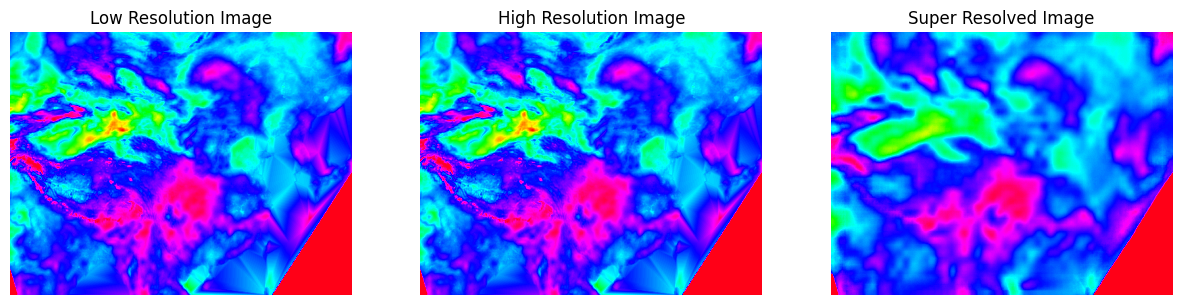

In [8]:
model = FSRCNN().to(device)
model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/FSRCNN_pet.pth'))
model.eval()  # 设置为评估模式

eva_image_path = 'D:/7_climate_10_520_400/12_PET/2020/PET_2020_07_01.tif'
tem_image_path = 'F:/3_climate_100_52_40/1_tem/2020/tem_2020_07_01.tif'
tem_min_image_path = 'F:/3_climate_100_52_40/3_tem_min/2020/tem_min_2020_07_01.tif'
tem_max_image_path = 'F:/3_climate_100_52_40/2_tem_max/2020/tem_max_2020_07_01.tif'
pr_image_path = 'F:/3_climate_100_52_40/7_tol_per/2020/per_2020_07_01.tif'
wind_image_path = 'F:/3_climate_100_52_40/4_wind_u/2020/wind_2020_07_01.tif'
ps_image_path = 'F:/3_climate_100_52_40/6_ps/2020/ps_2020_07_01.tif'
solar_image_path = 'F:/3_climate_100_52_40/8_solar_rad/2020/solar_rad_2020_07_01.tif'
ther_image_path = 'F:/3_climate_100_52_40/9_ther_rad/2020/ther_rad_2020_07_01.tif'
rh_image_path = 'F:/3_climate_100_52_40/11_rh/2020/rh_2020_07_01.tif'

eva_image = load_tiff_with_rasterio(eva_image_path)
tem_image = load_tiff_with_rasterio(tem_image_path)
tem_min_image = load_tiff_with_rasterio(tem_min_image_path)
tem_max_image = load_tiff_with_rasterio(tem_max_image_path)
pr_image = load_tiff_with_rasterio(pr_image_path)
pr_image = pr_image*1000
wind_image = load_tiff_with_rasterio(wind_image_path)
ps_image = load_tiff_with_rasterio(ps_image_path)
ps_image = ps_image/1000
solar_image = load_tiff_with_rasterio(solar_image_path)
solar_image = solar_image/86400
ther_image = load_tiff_with_rasterio(ther_image_path)
ther_image = ther_image/86400
rh_image = load_tiff_with_rasterio(rh_image_path)

transform = transforms.ToTensor()
tem_tensor = transform(tem_image).unsqueeze(0)
tem_min_tensor = transform(tem_min_image).unsqueeze(0)
tem_max_tensor = transform(tem_max_image).unsqueeze(0)
pr_tensor = transform(pr_image).unsqueeze(0)
wind_tensor = transform(wind_image).unsqueeze(0)
ps_tensor = transform(ps_image).unsqueeze(0)
solar_tensor = transform(solar_image).unsqueeze(0)
ther_tensor = transform(ther_image).unsqueeze(0)
rh_tensor = transform(rh_image).unsqueeze(0)
print(ther_tensor.shape)
lr_tensor= torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
print(lr_tensor.shape)
lr_tensor = lr_tensor.float().to(device)

vmin = eva_image[mask].min()
vmax = eva_image[mask].max()

model.to(device)
with torch.no_grad():
    sr_tensor = model(lr_tensor)
sr_image = sr_tensor.squeeze().cpu().numpy()

def plot_images(lr_image, hr_image, sr_image):


    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Low Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('High Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Super Resolved Image')
    plt.axis('off')

    plt.show()
plot_images(eva_image, eva_image, sr_image)

In [9]:
with rasterio.open(eva_image_path) as src:
    # 获取原始图像的地理信息（仿射变换矩阵和投影坐标系）
    transform = src.transform
    crs = src.crs
    profile = src.profile
profile.update(
    dtype=rasterio.float32,   # 数据类型为 float32
    count=1,                  # 1 个波段
    height=sr_image.shape[0], # 高度
    width=sr_image.shape[1],  # 宽度
    transform=transform        # 保持原始的地理变换信息
)

year = list(range(2000, 2024))
model.to(device)
transform = transforms.ToTensor()
for a_index, a in enumerate(year):
    start_date = f'{a}-01-01'
    end_date = f'{a}-12-31'
    date_range = pd.date_range(start=start_date, end=end_date)
    print(a)
    for b_index, b in enumerate(date_range):
        day_index = b_index
        date_day = date_range[day_index]
        date_day_year = date_day.year
        date_day_month = date_day.month
        date_day_day = date_day.day
        tem_path = f'F:/3_climate_100_52_40/1_tem/{a}/tem_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}/tem_min_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}/tem_max_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}/per_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}/wind_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ps_path = f'F:/3_climate_100_52_40/6_ps/{a}/ps_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}/solar_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}/ther_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        rh_path = f'F:/3_climate_100_52_40/11_rh/{a}/rh_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        
        output_path = f'J:/3_climate_output/1_climate_520_400/4_FSRCNN/12_pet/{a}/pet_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        
        tem_image = load_tiff_with_rasterio(tem_path)
        tem_tensor = transform(tem_image).unsqueeze(0) 
        tem_tensor = tem_tensor.float().to(device)
        
        tem_min_image = load_tiff_with_rasterio(tem_min_path)
        tem_min_tensor = transform(tem_min_image).unsqueeze(0) 
        tem_min_tensor = tem_min_tensor.float().to(device)

        tem_max_image = load_tiff_with_rasterio(tem_max_path)
        tem_max_tensor = transform(tem_max_image).unsqueeze(0) 
        tem_max_tensor = tem_max_tensor.float().to(device)

        pr_image = load_tiff_with_rasterio(pr_path)
        pr_image = pr_image*1000
        pr_tensor = transform(pr_image).unsqueeze(0) 
        pr_tensor = pr_tensor.float().to(device)

        ps_image = load_tiff_with_rasterio(ps_path)
        ps_image = ps_image/1000
        ps_tensor = transform(ps_image).unsqueeze(0) 
        ps_tensor = ps_tensor.float().to(device)

        wind_image = load_tiff_with_rasterio(wind_path)
        wind_tensor = transform(wind_image).unsqueeze(0) 
        wind_tensor = wind_tensor.float().to(device)

        solar_image = load_tiff_with_rasterio(solar_path)
        solar_image = solar_image/86400
        solar_tensor = transform(solar_image).unsqueeze(0) 
        solar_tensor = solar_tensor.float().to(device)

        ther_image = load_tiff_with_rasterio(ther_path)
        ther_image = ther_image/86400
        ther_tensor = transform(ther_image).unsqueeze(0) 
        ther_tensor = ther_tensor.float().to(device)

        rh_image = load_tiff_with_rasterio(rh_path)
        rh_tensor = transform(rh_image).unsqueeze(0) 
        rh_tensor = rh_tensor.float().to(device)

        lr_tensor = torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
        
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_image = sr_tensor.squeeze().cpu().numpy()
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(sr_image.astype(rasterio.float32), 1)  # 将 sr_image 写入为第一个波段

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
